In this notebook:

- Explore how to apply filters on Google Earth Engine
- Image estraction from Google Earth Engine
- Create fishnet
- Read TIFF image
- Extract probability values

# Imports and settings

In [1]:
# turn to True if Andrea using notebook
andrea = True

In [9]:
import pandas as pd
import ee
import geemap
import folium
from IPython.display import Image
import ipyleaflet # to show the map in the notebook
import math
from matplotlib import pyplot as plt

if andrea:

  from google.colab import drive
  drive.mount('/content/drive')

  import sys
  sys.path.insert(0,'/content/drive/MyDrive/src')
  from fishnet import Fishnet

else:

  import sys
  sys.path.append('../src')
  from fishnet import Fishnet

import warnings
warnings.filterwarnings('ignore')

# update files automatically
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [10]:
# from Google Colab
if andrea:
  ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=8f7pZmtqvRCyX6yVnC1fXYSdXXhe3Rgybs4xq-YnKyE&tc=FoNBTWyfiT5pI7SFu3Nkw2yyIZf5ciPouhmNE3-CZMU&cc=jJMGy_aPeEu1fGZAsDsgCZW1sG3dBbmB-SVIYbhRpCU

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk4NrqjL5Bp4AU4jau3IiaYzj7kHTRIh_4exultQK641eu36e3gIVWM

Successfully saved authorization token.


In [11]:
ee.Initialize(project="jpmorgancapstone")

# Explore how to apply filters on Google Earth Engine

In [ ]:
def create_map(
        bb_coords, # bounding box coordinates
        year,    # year of interest
        sentinel_layer = False, # default False, if True add sentinel layer to the map
        landcover_probability = False, # default False, if True add landcover layer to the map
        landcover_hillshade = False, # default False, if True add landcover layer to the map
        built_as_white = False # default False, if True built areas are white and rest is black
):
        
    Map = geemap.Map()
    Map.add_basemap('HYBRID')

    # Set the region of interest by simply drawing a polygon on the map
    region = Map.user_roi
    if region is None:
        region = ee.Geometry.BBox(bb_coords[0],bb_coords[1],bb_coords[2],bb_coords[3])
    rectangle = ee.Geometry.Rectangle(bb_coords)
    Map.centerObject(region)

    # Set start and end date
    start_date = f'{year}-05-01'
    end_date = f'{year}-09-01' 

    # get image from sentinel
    image = geemap.dynamic_world_s2(region, start_date, end_date)

    # add layers if requested
    if sentinel_layer:        
        vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
        Map.addLayer(image, vis_params, 'Sentinel-2 image')

    if landcover_probability:
        landcover = geemap.dynamic_world(region, start_date, end_date, return_type='probability')
        Map.addLayer(landcover, {}, 'Landcover')

    if landcover_hillshade:
        landcover = geemap.dynamic_world(region, start_date, end_date, return_type='hillshade')
        Map.addLayer(landcover, {}, 'Landcover')
        Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')

    if built_as_white:
        # Create a Dynamic World image collection
        dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
                .filterDate(start_date, end_date) \
                .filterBounds(region)

        # Create a mode composite
        classification = dw.select('label')
        dwComposite = classification.reduce(ee.Reducer.mode())

        # Extract the Built Area class
        builtArea = dwComposite.eq(6)

        # Define the visualization parameters
        dwVisParams = {
            'min': 0,
            'max': 8,
            'palette': [
                '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
                '#C4281B', '#A59B8F', '#B39FE1'
            ]
        }

        # Clip the composite and add it to the map
        Map.addLayer(dwComposite.clip(region), dwVisParams, 'Classified Composite')
        Map.addLayer(builtArea.clip(region), {}, 'Built Areas')

        Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')

        # Rename the bands
        dwComposite = dwComposite.rename(['classification'])
        builtArea = builtArea.rename(['built_area'])
        

    return Map



In [ ]:
bb_coords = [-96.8745,29.0542,-94.1144,30.6785]
year = 2022

In [ ]:
Map = create_map(bb_coords, year, landcover_hillshade=True)
Map

# Image extraction from the Google Earth Engine

In [28]:
#Parameters
region = ee.Geometry.BBox(bb_coords[0], bb_coords[1], bb_coords[2], bb_coords[3])
rectangle = ee.Geometry.Rectangle(bb_coords)

# Set start and end date
year = 2022
start_date = f'{year}-05-01'
end_date = f'{year}-09-01' 

#Initialize the map
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.centerObject(region)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [29]:
#Extract a satellite image
image = geemap.dynamic_world_s2(region, startDate, endDate)

#Extract the Dynamic World Labels
landcover = geemap.dynamic_world(region, startDate, endDate, return_type='visualize')

#Add to map
Map.addLayer(landcover, {}, 'Land Cover')

# add bounding box that we extract to the map
Map.addLayer(rectangle, {}, 'Bounding Box')

In [30]:
# Get the coordinates of the bounding box
coords = region.getInfo()['coordinates'][0]

# resolution in meters per pixel
res = 10

# Calculate the width and height of the bounding box in meters
width = ee.Geometry.Point(coords[0]).distance(ee.Geometry.Point(coords[1]))
height = ee.Geometry.Point(coords[1]).distance(ee.Geometry.Point(coords[2]))

# Print the width and height
print('Bounding Box Width:', width.getInfo(), 'meters')
print('Bounding Box Height:', height.getInfo(), 'meters')

# If 10m is one pixel, total number of required pixel in the image (witdh and height):
print('Image width (pixels): ', math.ceil(width.getInfo() / res))
print('Image height (pixels): ', math.ceil(height.getInfo() / res))
print("Total number of pixels: ", math.ceil(width.getInfo() / res) * math.ceil(height.getInfo() / res))

Bounding Box Width: 74882.54092823579 meters
Bounding Box Height: 46626.134124752236 meters
Image width (pixels):  7489
Image height (pixels):  4663
Total number of pixels:  34921207


In [31]:
### Save the image
export_params = {
    'image': landcover,
    'description': 'land_labels_test_export2',
    'folder': '/ge_exports/',  # Google Drive folder name
    'scale': 10,  # Resolution in meters
    'region': region,
    'fileFormat': 'GeoTIFF',
    'maxPixels': 1e10,  # Increase this value if you encounter an error due to the pixel limit
}

export_task = ee.batch.Export.image.toDrive(**export_params)
export_task.start()

# Create a fishnet

In [32]:
if andrea:
  fishnet_creator = Fishnet('/content/drive/MyDrive/Texas_State_Boundary/State.shp', 4)
else:
  fishnet_creator = Fishnet('../Gis/Texas_State_Boundary/State.shp', 4, overlay_method='union', clip = False) # Victor

fishnet = fishnet_creator.create_fishnet()
fishnet.head()

100%|██████████| 63/63 [00:00<00:00, 531.49it/s]


Generating polygons...
Cliping fishinet to boundaries...
Success. Fishnet created.


,id,OBJECTID,FIPS,CREATE_USE,CMNT,SHAPE_Leng,SHAPE_Area,geometry
0,53,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-97.50226 26.00656, -97.50226 25.894..."
1,54,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-97.50226 26.00656, -97.33292 26.006..."
2,55,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-97.33292 26.00656, -97.16359 26.006..."
3,56,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-97.16359 26.00656, -97.15080 26.006..."
4,126,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-98.34892 26.17589, -98.34892 26.153..."


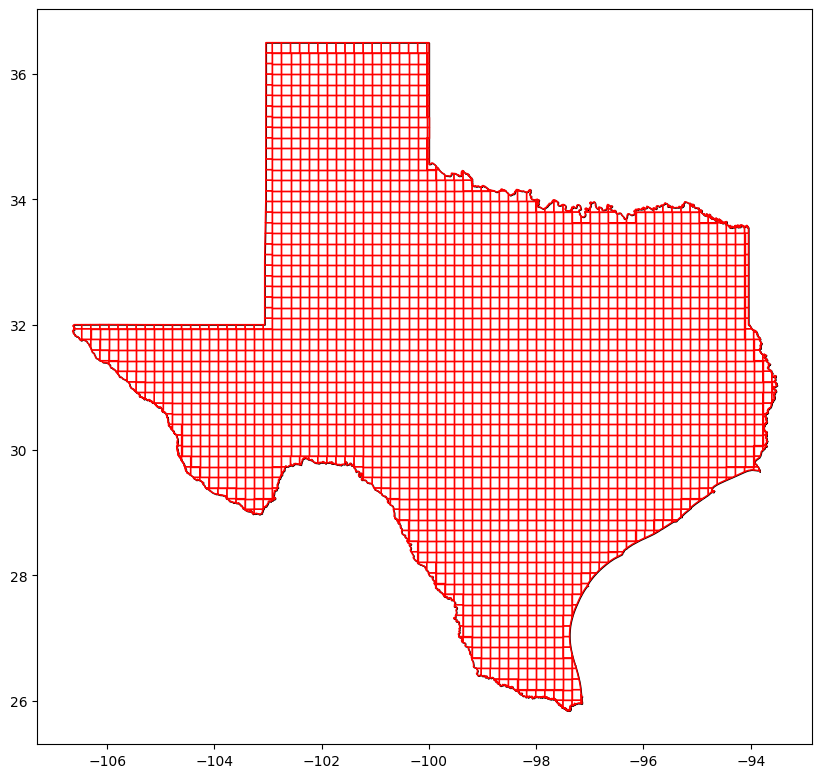

In [33]:
fishnet_creator.plot_fishnet() # with Clip = True

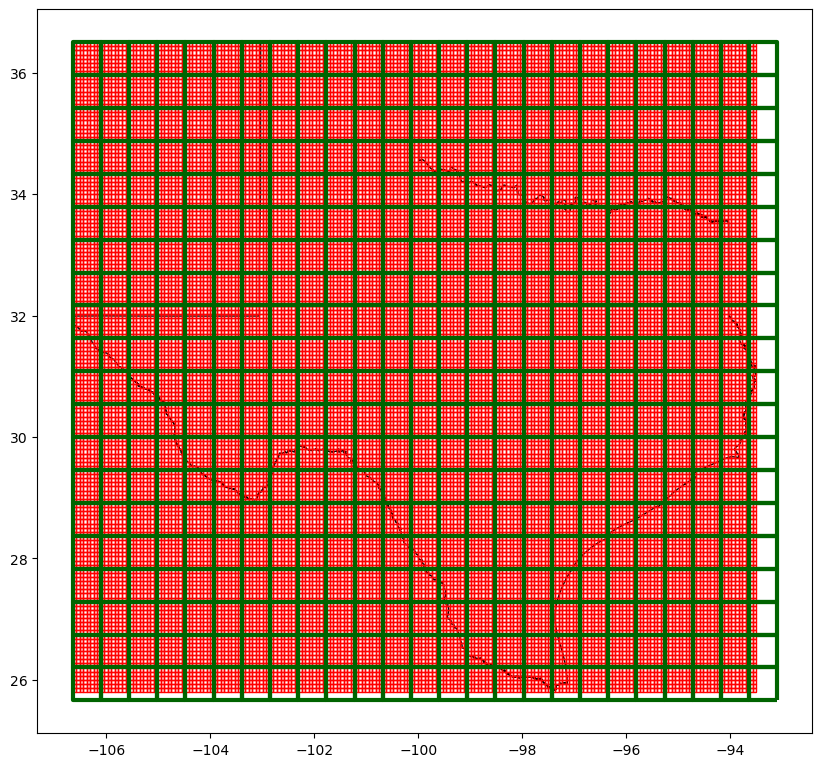

In [ ]:
fishnet_creator.plot_fishnet() # with clip = False

In [ ]:
fishnet_creator.batch(4)  # creates batches of 4miles x 4miles

In [ ]:
# this specific fishnet was 0.25miles granular and 4miles edge of each batch.
fishnet_creator.save('../Gis/Fishnet/fishnet_quarter_mile.pkl') # saves the fishnet to a pickle file

# Read a TIFF Image in Python

Shape: (4683, 8588, 3)
Data type: uint8
Minimum value: 27
Maximum value: 228


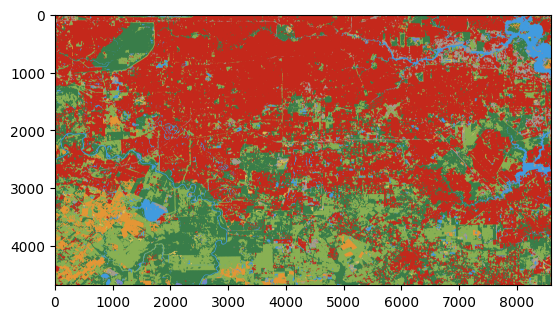

In [34]:
import imageio
import numpy as np

# Load the image
if andrea:
  image = imageio.imread('/content/drive/MyDrive/ ge_exports /land_labels_test_export2.tif') # for Andrea
else:
  image = imageio.imread('../Images/land_labels_test_export2.tif') # for Victor

# Print some information about the image
print('Shape:', image.shape)
print('Data type:', image.dtype)
print('Minimum value:', image.min())
print('Maximum value:', image.max())

#plot the image
plt.imshow(image)

# Extract probability values

In [35]:
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
        .filterDate(start_date, end_date) \
        .filterBounds(region)

dwImage = ee.Image(dw.first())

In [36]:
probabilityBands = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
]

probabilityImage = dwImage.select(probabilityBands)

# Create the image with the highest probability value at each pixel.
top1Probability = probabilityImage.reduce(ee.Reducer.max())

In [37]:
top1Probability